Matison Lakstigala
Earth Data Analytics 2023
Project Report

# Visualizing Percent Change in NDVI Land Cover to Measure Vegetation Health in Brighton, Colorado

## Introduction
An unhealthy environment vulnerable to flash floods, wildfires, and droughts can worsen the impacts of climate change by reducing the landscape's ability to absorb and retain water, increasing erosion and soil degradation. This can lead to a loss of vegetation, biodiversity, and wildlife habitats, which can further degrade the ecosystem and exacerbate the impacts of climate change.

Understanding past conditions is crucial for a municipality’s informed decision-making and effective resource management, such as which practices to prioritize, and how to effectively monitor and evaluate progress towards sustainability and climate resilience goals. This knowledge can enhance our understanding of management strategies that balance conservation and resource use, while maintaining ecosystem services and resilience to environmental changes, ultimately promoting a healthier and more sustainable city.

My aim as a horticulturist working for the City of Brighton, Colorado is to enhance the historical and ecological understanding of the landscape by analyzing a curated list of environmentally sensitive areas found throughout the city. This will enable decision-makers to make informed choices about how these properties can withstand the immediate effects of climate change.

Other similarly related examples of efforts on this topic area include a paper on using NDVI for greenness exposure assessments and policy interventions in urban greening:
https://www.sciencedirect.com/science/article/pii/S0013935122024823#cebib0010

In addition, a link is provided for NASA Scientific Visualization System’s article on NDVI anomalies revealing areas of likely drought in Colorado: 
https://svs.gsfc.nasa.gov/2939


## Study Area
Brighton, Colorado is a city located in Adams County, situated approximately 20 miles northeast of downtown Denver and covers an area of approximately 21 square miles. The area has experienced a significant population boom in recent years, with a current population of around 41,000 people. This growth has been driven by a combination of factors, including its proximity to Denver, a strong local economy, and affordable housing. 

Despite the rapid urbanization and development of Brighton, the area has managed to preserve its agricultural roots. The region boasts numerous farms and ranches, which contribute to the local economy while maintaining the connection to the city's rich agricultural heritage. With a semi-arid climate characterized by hot summers and cold winters, the area has long been an ideal location for growing crops such as corn, wheat, and alfalfa.

However, the rapid growth and development of the area have put significant pressure on the local ecosystem. The natural habitats of prairie grasslands, wetlands, and riparian areas have been threatened by the expansion of urban areas and agricultural lands, leading to a decline in biodiversity and ecological health. To counteract this trend, the city has taken steps to protect these ecological features, including the establishment of conservation easements and other preservation measures.

To ensure the long-term sustainability of the region, it is important to implement sustainable land use management practices. Research into best practices for ecological, social, and economic sustainability can provide valuable insights to guide decision-making and resource management. By identifying the most effective strategies, the City of Brighton can help to balance the needs of development and preservation, ensuring a healthy ecosystem for future generations. Through the integration of sustainable practices, Brighton can continue to thrive as a vibrant community while maintaining its connection to its agricultural heritage and natural surroundings.


## Methods
The purpose of this project is to collect and analyze data to visualize and measure drought indicators from 1990 to present in order to promote future conservation efforts and focus time and resources to the most sensitive areas of the city.

I’ve identified five areas within the city to be designated as “priority conservation areas.” A PCA will be defined as an area desirable to maintain or enhance through protection, restoration, or sustainable stewardship, such as an area with:

* Significant biodiversity (pocket prairie) (Mattive Open Space)  							
* Critical habitat for endangered or vulnerable species (bald eagle, snowy egret) (Ken Mitchell Open Space) 				 					
* Wildlife habitat (beavers, prairie dogs, raptors, owls, etc) (Morgan Smith Nature Area)  					 				

* Land with historical agriculture use (Wagner-Mayhew)  						
* Land that provides essential ecosystem services (Erger’s Pond)

By analyzing the data, I can identify any significant changes in vegetation land cover, such as deforestation, reforestation, or changes in plant species. These changes can then be compared against historical data, identifying the important biotic and abiotic structures within each PCA's boundaries, such as rivers, streams, and wetlands. These structures play a critical role in the ecosystem and can provide insight into potential threats to the area.

## Data
Normalized Difference Vegetation Index (NDVI) is used to assess the greenness in the vegetation cover. The range of values obtained is between −1 and +1. Only positive values correspond to vegetated zones; the higher the index, the greater the chlorophyll content of the target.

This index is important for agricultural drought monitoring, used to estimate crop yields, pasture performance, and rangeland carrying capacities, assess nutrient deficiencies, etc. Its value is directly related to percent of ground cover, photosynthetic activity of the plant, and surface water as well as others.

NDVI calculations will be generated for each year in the study period (1990-2023) clipped to each of the 5 study areas using aerial imagery sourced from NASA satellites and downloaded as image files. Satellite data will be sourced from LandSat 5-9 aerial imagery 1990-2023 downloaded with Google Earth Engine. Supplemental data that will be used include native data stored within Brighton GIS department’s city-wide repository such as shapefiles, inventories, and map layers (elevation maps, roads and rails, watershed data, city owned parcel boundaries, parks property, farmable properties, bald eagle habitat information, and data contained in neighboring county repositories).

To connect to Landsat, calculate NDVI, classify land cover, and calculate percent change of land cover, you can use a combination of the rioxarray, geopandas, earthpy, numpy, os, and matplotlib libraries in Python to implement these steps in the following order:

1) Obtain Landsat imagery data for the study area from the USGS Earth Explorer or a similar source.

Go to the USGS Earth Explorer website (https://earthexplorer.usgs.gov/) and create an account if necessary.
Select the study area and date range for the Landsat imagery.
Choose the Landsat satellite and corresponding bands for the analysis.
Download the Landsat imagery data in GeoTIFF format.
Load the Landsat imagery into Python using the rioxarray package.

2) Load the Landsat imagery into Python using the rioxarray package.

3) Calculate the NDVI for each image using the formula: (NIR - RED) / (NIR + RED), where NIR is the near-infrared band and RED is the red band of the Landsat imagery.

4) Classify the NDVI rasters into 5 different land cover classes based on the NDVI values between -1 and 1. You can use the numpy package to create a mask for each land cover class based on the NDVI threshold values.

5) Calculate the percent change of land cover between two time periods by subtracting the NDVI values of the earlier time period from the NDVI values of the later time period and dividing by the NDVI values of the earlier time period.

6) Save the NDVI rasters and land cover classifications as .tif files using the rioxarray package.

7) Calculate the percent change of land cover between two time periods by subtracting the NDVI values of the earlier time period from the NDVI values of the later time period and dividing by the NDVI values of the earlier time period.

8) Save the NDVI rasters and land cover classifications as .tif files using the rioxarray package.

Here's an example code that connects to Landsat, downloads Landsat 8 imagery for the study area over the study period, calculates NDVI for each image, classifies the NDVI rasters into 5 land cover classes, calculates the percent change of land cover, and saves the rendered image of January 1st, 1990 in .tif, .gif, and geotiff file formats:

In [1]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
from glob import glob
import os
import earthpy as et
import geopandas as gpd
import imageio
import numpy as np
import pathlib
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Get data and set working directory
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'landsat-brighton'))

landsat_ds_red = []

landsat_ds_nir = []

is_shapefile_loaded = False

for file_name in sorted(glob("*_L2SP_*_*_*_02_T1_SR_B*.TIF")):
    try:
        product = int(file_name[3])
    except:
        continue
    
    try: 
        band = int(file_name[-5])
        
    except:
        continue
    if product < 8: 
        if band==3:
            band_name = "red"
        elif band==4:
            band_name = "nir"
        else:
            continue
    else:
        if band==4:
            band_name = "red"
        elif band==5:
            band_name = "nir"
        else:
            continue
            
    try:
        date = pd.to_datetime(file_name[17:25])
    except:
        continue
    
    ds = rxr.open_rasterio(file_name, masked=True).squeeze()
    ds = ds.assign_coords(date=date)
    ds = ds.expand_dims("date")
    
    if not is_shapefile_loaded: 
        brighton_bounds = "Brighton_Boundary.shp"
        
        # Replace city_bounds_gdf with each study area shapefile
    
    #     ergers_pond_bounds = "Ergers_Pond.shp"
    #     ken_mitchell_bounds = "Ken_Mitchell_Open_Space.shp"
    #     mattive_bounds = "Mattive_Open_Space.shp"
    #     morgan_smith_bounds = "Morgan_Smith_Nature_Area.shp"
    #     wagner_mayhew_bounds = "Wagner_Mayhew_Property.shp"
    
    # Save each decadal average figure as a .tif image to your working directory
        # for shapefile, ken_mitchell_bounds in study_area_bounds
            # study_area_bounds.rio.to_raster("ndvi_{}.tif".format(decade))
        
        city_bounds_gdf = gpd.read_file(brighton_bounds)

        city_bounds_gdf = city_bounds_gdf.to_crs(ds.rio.crs)

        is_shapefile_loaded = True
    
    ds = ds.rio.clip_box(*city_bounds_gdf.total_bounds)
    
    if band_name=="red":
        landsat_ds_red.append(ds)
    if band_name=="nir":
        landsat_ds_nir.append(ds)

In [3]:
red_landsat_ds = xr.concat(landsat_ds_red, dim=("date")).sortby("date")
nir_landsat_ds = xr.concat(landsat_ds_nir, dim=("date")).sortby("date")

nir_landsat_ds

<xarray.DataArray (date: 34, y: 495, x: 423)>
array([[[20117., 19120., 17621., ..., 19235., 18237., 18612.],
        [19369., 19120., 18371., ..., 17988., 19111., 18612.],
        [17996., 18745., 18620., ..., 16238., 17363., 17238.],
        ...,
        [17116., 16992., 17364., ..., 18727., 18727., 18353.],
        [17116., 17364., 17490., ..., 18353., 18353., 18478.],
        [16741., 17240., 17490., ..., 17979., 17854., 17854.]],

       [[21288., 21671., 22052., ..., 19751., 19118., 18738.],
        [21415., 20775., 20903., ..., 18232., 18992., 19117.],
        [19623., 19878., 20262., ..., 15816., 17215., 16833.],
        ...,
        [19298., 20065., 20196., ..., 17867., 17991., 18116.],
        [17769., 18410., 19052., ..., 17116., 17367., 17492.],
        [18409., 18412., 18160., ..., 16116., 16242., 16241.]],

       [[19275., 20942., 22349., ..., 18324., 18196., 17685.],
        [18633., 18762., 19147., ..., 17557., 18579., 18324.],
        [16830., 17218., 17347., ..., 16917., 17685., 17429.],
        ...,
...
        [18507., 21689., 19194., ..., 18699., 18908., 19113.],
        [16793., 18714., 18562., ..., 18820., 18965., 19008.],
        [17376., 20320., 19063., ..., 18629., 18573., 18717.]],

       [[21482., 21047., 21414., ..., 17210., 17389., 16607.],
        [21556., 20984., 20673., ..., 17368., 16972., 16725.],
        [21049., 21210., 20655., ..., 17265., 17542., 17224.],
        ...,
        [20142., 20403., 18486., ..., 17743., 17827., 17795.],
        [17997., 19385., 18336., ..., 18518., 18529., 18615.],
        [15911., 17643., 18351., ..., 18399., 18466., 18543.]],

       [[19490., 22641., 26076., ..., 19547., 20115., 19770.],
        [18335., 19740., 21691., ..., 19096., 18212., 17803.],
        [18961., 19319., 18696., ..., 18832., 19142., 19592.],
        ...,
        [18735., 20939., 19131., ..., 16703., 16582., 16262.],
        [16625., 19022., 20893., ..., 16997., 17063., 17295.],
        [18607., 20396., 19486., ..., 16635., 16713., 16752.]]],
      dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 5.115e+05 5.116e+05 ... 5.242e+05 5.242e+05
  * y            (y) float64 4.431e+06 4.431e+06 ... 4.417e+06 4.417e+06
  * date         (date) datetime64[ns] 1990-06-23 1991-06-10 ... 2023-06-18
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [4]:
# Calculate the NDVI for each image using the formula: (NIR - RED) / (NIR + RED)
ndvi = (nir_landsat_ds - red_landsat_ds) / (nir_landsat_ds + red_landsat_ds)

class_bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
class_bins

ndvi_decade = ndvi.resample(date="10AS", skipna=True).mean()

ndvi_decade["date"] = ndvi_decade.date.dt.year

ndvi_brighton_co_class = xr.apply_ufunc(np.digitize,
                                     ndvi_decade,
                                     class_bins)

ndvi_brighton_co_class

<xarray.DataArray (date: 4, y: 495, x: 423)>
array([[[5, 6, 6, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        ...,
        [5, 6, 6, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        ...,
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[5, 6, 6, ..., 5, 5, 5],
        [5, 5, 6, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5],
        ...,
        [5, 6, 6, ..., 5, 5, 5],
        [5, 6, 5, ..., 5, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]],

       [[5, 6, 6, ..., 5, 5, 5],
        [6, 6, 6, ..., 5, 5, 5],
        [6, 6, 6, ..., 5, 5, 5],
        ...,
        [5, 6, 6, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 5],
        [5, 6, 6, ..., 5, 5, 5]]])
Coordinates:
    band         int64 1
  * x            (x) float64 5.115e+05 5.116e+05 ... 5.242e+05 5.242e+05
  * y            (y) float64 4.431e+06 4.431e+06 ... 4.417e+06 4.417e+06
    spatial_ref  int64 0
  * date         (date) int64 1990 2000 2010 2020

ValueError: 'tab3c' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

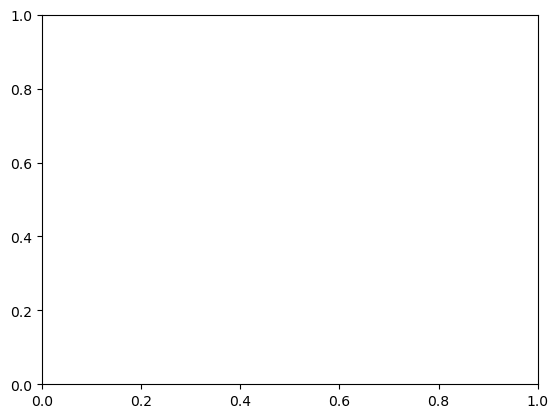

In [5]:
(ndvi_decade.to_dataframe(name="NDVI") 
 .reset_index()
 .pivot(columns="date", values="NDVI", index=["x","y"])
 .plot(alpha=0.5, kind="hist", colormap="tab3c")
)

In [ ]:
ndvi_brighton_co_class.plot()

In [ ]:
# Calculate the percent change of land cover between two decades by:
# Subtracting the NDVI values of the earlier time period from the NDVI values of the later decade and
# Dividing by the NDVI values of the earlier decade

ndvi_1 = ndvi_decade.sel(date="1990").mean()
ndvi_2 = ndvi_decade.sel(date="2000").mean()
ndvi_3 = ndvi_decade.sel(date="2010").mean()
ndvi_4 = ndvi_decade.sel(date="2020").mean()

change_percent_1990_2000 = ((ndvi_2 - ndvi_1) / ndvi_1) * 100
change_percent_2000_2010 = ((ndvi_3 - ndvi_2) / ndvi_2) * 100
change_percent_2010_2020 = ((ndvi_4 - ndvi_3) / ndvi_3) * 100

print(change_percent_1990_2000, change_percent_2000_2010, change_percent_2010_2020)

In [ ]:
# Save each decadal average figure as a .tif image to your working directory
for decade, NDVI_1_decade in ndvi_decade.groupby("date"):
    NDVI_1_decade.rio.to_raster("ndvi_{}.tif".format(decade))

In [ ]:
# Create a visualization of the NDVI for each decade as a .tif image

# Load the NDVI rasters for each time period
ndvi_1990 = rxr.open_rasterio("ndvi_1990.tif")
ndvi_2000 = rxr.open_rasterio("ndvi_2000.tif")
ndvi_2010 = rxr.open_rasterio("ndvi_2010.tif")
ndvi_2020 = rxr.open_rasterio("ndvi_2020.tif")

# Create a figure with four subplots, one for each time period
fig, axs = plt.subplots(1, 2, 3, 4, figsize=(10, 5))

# Plot the NDVI map for each time period
ndvi_1990.plot(ax=axs[0], cmap=cmap, vmin=-1, vmax=1, cbar_label="NDVI")
ndvi_2000.plot(ax=axs[1], cmap=cmap, vmin=-1, vmax=1, cbar_label="NDVI")
ndvi_2010.plot(ax=axs[2], cmap=cmap, vmin=-1, vmax=1, cbar_label="NDVI")
ndvi_2020.plot(ax=axs[3], cmap=cmap, vmin=-1, vmax=1, cbar_label="NDVI")

# Add titles and labels to the subplots
axs[0].set_title("Change in NDVI from 1990 - 2000")
axs[1].set_title("Change in NDVI from 2000 - 2010")
axs[2].set_title("Change in NDVI from 2010 - 2020")
axs[3].set_title("Change in NDVI from 2020 - 2023")
axs[0].set_xlabel("Longitude")
axs[1].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

# Save the figure as a .tif image
plt.savefig("city_brighton_bounds_ndvi.tif")

# Create HTML version of your notebook and save it in the current working directory
# os.system('jupyter nbconvert --to html --no-input ndvi_brighton_co.ipynb')

## Outputs:
NDVI images: 33 .tif images for 5 study areas, for a total of 165 images (to be compiled into a .gif format)

StoryMap: Develop a publicly accessible ArcGIS StoryMap that integrates maps, legends, text, photos and video. StoryMaps offer a novel way of communicating insights on these complex issues that can engage a wide range of audiences, including the public and stakeholders

Summary of Findings: Produce a table that presents the main findings in a transparent, structured and simple tabular format to provide key information concerning the certainty or quality of evidence, the magnitude of effect, and communication of available scientific data on the main outcomes in a presentable format to city planners, sustainability committees, and interested work-groups.

##### Conclusion:
Challenges I anticipate with working with this data include cropping out information contained within massive publicly available datasets such as Landsat.

